# Unsupervised image denoising

## Import libraries

In [101]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.feature import hog
from math import log10
from sklearn import svm
from tqdm.notebook import tqdm
import os
import matplotlib.image as img
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Load data

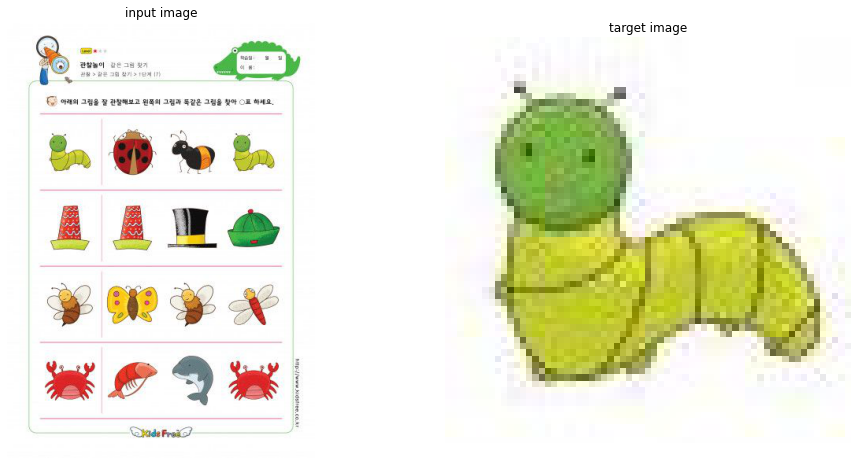

In [102]:
directory_data  = './'
image_train_data   = 'image_train2.jpg'
image_target_data   = 'image_target2.jpg'
image_train      = img.imread(os.path.join(directory_data, image_train_data))
image_target    = img.imread(os.path.join(directory_data,image_target_data))
# image_train = np.concatenate((image_train,image_train))
# image_train = np.concatenate((image_train,image_train),axis=1)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image_train, cmap = 'gray')
plt.title('input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_target, cmap = 'gray')
plt.title('target image')
plt.axis('off')

num_train   = image_train.shape
num_target  = image_target.shape

## Compute Derivative First Order, 미분을 이용해서 윤곽 정보만 땀

In [103]:
def compute_derivative_first_order(data, axis): 

    D = np.pad(data,(1,1), mode = 'edge')   # use numpy.pad function 
    if axis == 'x':
      derivative = np.roll(D,1)-D   # use numpy.roll function
        
    elif axis == 'y':
      derivative = np.roll(D,1,axis=0) -D# use numpy.roll function
        
    dD = derivative[1:data.shape[0]+1,1:data.shape[1]+1]   # remove the first and the last rows and columns for the boundary condition

    return(dD)

In [104]:
def gray_scale_derivative(image):
  if len(image.shape) == 3:
    image = image.mean(2)
  dx = compute_derivative_first_order(image,'x')
  dy = compute_derivative_first_order(image,'y')
  gradient_mag = np.sqrt(np.power(dx,2) + np.power(dy,2) )
  return gradient_mag

In [105]:
import math
def naive_image_rotate(image, degree):
    '''
    This function rotates the image around its center by amount of degrees
    provided. The size of the rotated image is same as that of original image.
    '''
    # First we will convert the degrees into radians
    rads = math.radians(degree)

    # We consider the rotated image to be of the same size as the original
    rot_img = np.zeros(image.shape)

    # Finding the center point of rotated (or original) image.
    height = rot_img.shape[0]
    width  = rot_img.shape[1]

    midx,midy = (width//2, height//2)

    for i in range(rot_img.shape[0]):
        for j in range(rot_img.shape[1]):
            x= (i-midx)*math.cos(rads)+(j-midy)*math.sin(rads)
            y= -(i-midx)*math.sin(rads)+(j-midy)*math.cos(rads)

            x=round(x)+midx 
            y=round(y)+midy 

            if (x>=0 and y>=0 and x<image.shape[0] and  y<image.shape[1]):
                rot_img[i,j] = image[x,y]

    return rot_img 

Normalize input image so that the range of image is [0,1]

In [106]:
print('*************************************************')
print('size of train :', image_train.shape)
print('*************************************************')
print('size of target :', image_target.shape)

*************************************************
size of train : (553, 391, 3)
*************************************************
size of target : (65, 65, 3)


*************************************************
size of train : torch.Size([553, 391])
*************************************************
size of target : torch.Size([65, 65])
tensor(11.4959, dtype=torch.float64)


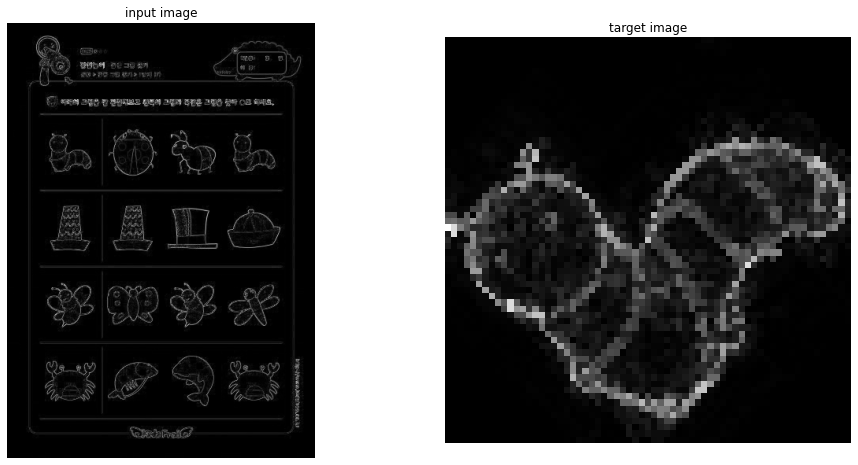

In [123]:
rotate_180 = naive_image_rotate( gray_scale_derivative(image_target),45)
image_train_gray = torch.from_numpy(gray_scale_derivative(image_train))
image_target_gray = torch.from_numpy( (rotate_180))
print('*************************************************')
print('size of train :', image_train_gray.shape )
print('*************************************************')
print('size of target :', image_target_gray.shape)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image_train_gray, cmap = 'gray')
plt.title('input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_target_gray, cmap = 'gray')
plt.title('target image')
plt.axis('off')
print(image_train_gray.mean())

In [108]:
def window_corr(input, window, h ,w,window_mean, window_std, stride=1, degree = 0):
 
  window_h, window_w = window.shape     
  h_start = h*stride # 시작지점에 stride 적용
  h_end = h_start + window_h 
  w_start  = w*stride # 시작지점에 stride 적용
  w_end = w_start + window_w
  target = input[h_start:h_end, w_start:w_end]
  if degree != 0:
    target = torch.from_numpy(naive_image_rotate(target , degree))
  target_std = target.std()
  target_mean = target.mean()
  result = ((target - target_mean) *(window-window_mean)).mean()/(target_std*window_std)
  return result

In [109]:
def cross_correlation(image, window, stride=1, pad=0):
  h, w = image.shape

  window_h, window_w = window.shape

  window_std = window.std()
  window_mean = window.mean()
  out_h = int((h+2*pad-window_h)/stride +1)
  out_w = int((w+2*pad-window_w)/stride +1)
  input = torch.nn.functional.pad(input=image, pad=(pad,pad,pad,pad), mode='constant', value = 0)
  # add padding to height and width. 
  #  # padding으로 모양이 커진 in_X
  # print(n, n_f, out_h, out_w)
  out = torch.zeros((out_h, out_w))
  for h in range(out_h): 
    for w in range(out_w):
      out[h, w] = window_corr(input, window, h, w , window_mean= window_mean, window_std= window_std,stride= stride)
  return out

In [110]:
def cross_correlation_v2_rotate(image, window, stride=1, pad=0):
  h, w = image.shape

  window_h, window_w = window.shape

  window_std = window.std()
  window_mean = window.mean()
  out_h = int((h+2*pad-window_h)/stride +1)
  out_w = int((w+2*pad-window_w)/stride +1)
  input = torch.nn.functional.pad(input=image, pad=(pad,pad,pad,pad), mode='constant', value = 0)
  arr = []
  out = torch.zeros((out_h, out_w))
  for h in range(out_h): 
    for w in range(out_w): 
      # for degree in range(0,360):
       
      ret = window_corr(input, window, h, w , window_mean= window_mean, window_std= window_std,stride= stride,degree=45)
      arr.append(ret)
      out[h,w] = max(arr)

  return out

## Cross Correlation을 이용한 output

In [117]:
# print(image_target_gray.shape)
num_train_row = image_train.shape[0]
num_train_col = image_train.shape[1]
num_target_row = image_target_gray.shape[0]
num_target_col = image_target_gray.shape[1]
# print(image_target_gray)

padding = num_target_col // 2
# print(padding)
out = cross_correlation_v2_rotate(image = image_train_gray,window = image_target_gray,stride = 1, pad = padding)
#결과 값 중 가장 높은 것의 인덱스를 가져옴

# 색이 진할 수록 높은것

KeyboardInterrupt: 

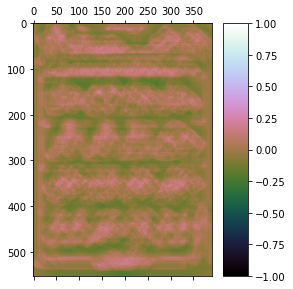

In [112]:
plt.matshow(out,cmap = 'cubehelix') # colormap을 이용해서 cross correlation 값이 높은 곳을 나타냄,

plt.colorbar(shrink=0.8, aspect=10)
plt.clim(-1.0, 1.0)
plt.show()

In [113]:
print(out.max())
other = torch.zeros(out.shape)
indices = torch.ones(out.shape)
ret1 = torch.where(out > 0.8,indices,other)
print(ret1.shape)


tensor(0.2672)
torch.Size([553, 391])


In [114]:
indices = ret1.nonzero()

In [115]:
# print(out.shape)
# y = out.tonp.view([-1])
# print(y.shape)
# x = torch.tensor(range(0, y.shape[0]))
# plt.scatter(x,y)
# feature = torch.zeros((len(y),2))
# feature[:,0 ] = x
# feature[:,1] = y
# print(feature.shape)
# ret = out.argmax() #결과 값 중 가장 높은 것의 인덱스를 가져옴

# x =  ret % num_train_col # x,y 인덱스를 계산
# y = ret // num_train_col

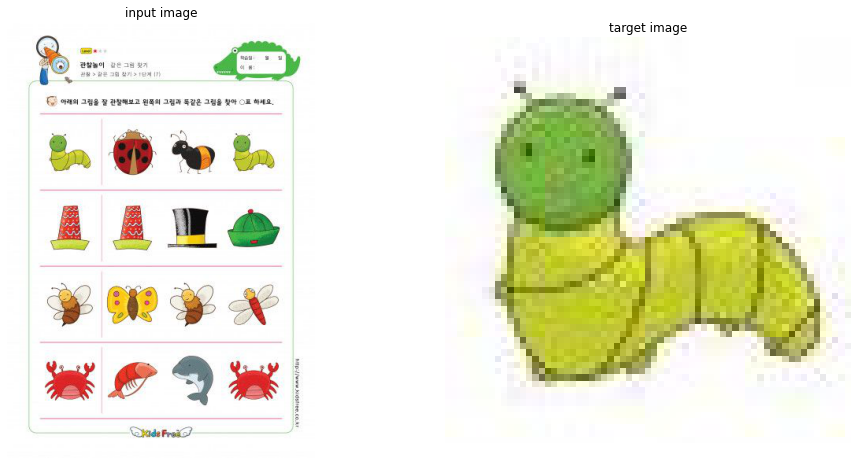

In [116]:
import matplotlib.patches as patches

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image_train, cmap = 'gray')
for x,y in indices:
  
  plt.gca().add_patch(patches.Rectangle((y -padding ,x-padding),width = num_target_row,height = num_target_col,edgecolor = 'deeppink',facecolor='lightgray',fill = False,))
plt.title('input image')
plt.axis('off')
plt.subplot(122)
plt.imshow(image_target, cmap = 'gray')
plt.title('target image')
plt.axis('off')

plt.show()